In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from deepface import DeepFace as df
#from retinaface import RetinaFace as m
from PIL import Image
#import imagehash
import pandas as pd
from pymongo import MongoClient
from deepface.commons import functions
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import numpy as np

In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the folder containing known faces
known_faces_folder = "Data/known_faces"

# List all subfolders (each subfolder represents a person)
person_folders = [os.path.join(known_faces_folder, person) for person in os.listdir(known_faces_folder) if os.path.isdir(os.path.join(known_faces_folder, person))]

# Initialize lists to store file paths
all_images = []
all_labels = []

# Iterate over person folders
for label, person_folder in enumerate(person_folders):
    # List all image files in the person folder
    image_files = [os.path.join(person_folder, image) for image in os.listdir(person_folder) if image.endswith(".jpg") or image.endswith(".png")]
    
    # Add image files and corresponding labels to the lists
    all_images.extend(image_files)
    all_labels.extend([label] * len(image_files))

# Split the data into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

# Define paths for train and val folders
train_folder = "Data/training"
val_folder = "Data/validation"

# Create train and val folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Move train images to train folder
for image, label in zip(train_images, train_labels):
    person_name = os.path.basename(os.path.dirname(image))
    destination_folder = os.path.join(train_folder, person_name)
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(image, destination_folder)

# Move val images to val folder
for image, label in zip(val_images, val_labels):
    person_name = os.path.basename(os.path.dirname(image))
    destination_folder = os.path.join(val_folder, person_name)
    os.makedirs(destination_folder, exist_ok=True)
    shutil.copy(image, destination_folder)

# Fine-tune FaceNet model
base_model = MobileNetV2(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(person_folders), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Image data generators for train and val sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator))



Found 43 images belonging to 34 classes.
Found 11 images belonging to 11 classes.
Epoch 1/10
2/2 [==============================] - 9s 3s/step - loss: 4.0886 - accuracy: 0.0000e+00 - val_loss: 4.1924 - val_accuracy: 0.0909
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 2.4536 - accuracy: 0.2791 - val_loss: 4.7753 - val_accuracy: 0.0909
Epoch 3/10
2/2 [==============================] - 3s 958ms/step - loss: 1.5997 - accuracy: 0.6744 - val_loss: 4.6988 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.9735 - accuracy: 0.8605 - val_loss: 4.6821 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 3s 990ms/step - loss: 0.6125 - accuracy: 0.9767 - val_loss: 4.7228 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 3s 953ms/step - loss: 0.3079 - accuracy: 1.0000 - val_loss: 5.0034 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss

In [15]:
model.save('Data/trained_model.h5')


In [23]:
from tensorflow.keras.models import load_model

# Load your fine-tuned model
fine_tuned_model = df.build_model('Data/trained_model.h5')

# Perform face recognition using your fine-tuned model
result = df.verify(detected_faces[0], "Data\known_faces\Devanarayan_S_R\Devanarayan_S_R.jpg", model_name=fine_tuned_model)

# Print result
print(result)

ValueError: Invalid model_name passed - Data/trained_model.h5

In [24]:
import sys

In [26]:
sys.version


'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# Define the data generators for train and validation data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the paths to your train and validation data directories
train_folder = 'Data/training'
val_folder = 'Data/validation'

# Create data generators for train and validation data
train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

val_generator = val_datagen.flow_from_directory(
        val_folder,
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse')

# Check if images are found in train and validation directories
print("Train images found:", len(train_generator.filepaths))
print("Validation images found:", len(val_generator.filepaths))


Found 43 images belonging to 34 classes.
Found 11 images belonging to 11 classes.
Train images found: 43
Validation images found: 11


In [69]:
import cv2
import numpy as np
from datetime import datetime

class VideoCaptureManager:
    def __init__(self, frame_size=(640, 480), codec='XVID'):
        self.frame_size = frame_size
        self.codec = codec
        self.is_capturing = False
        self.capture_duration = 0
        self.frames_buffer = []  # Store frames in a temporary buffer

    def start_capture(self, capture_duration):
        self.capture_duration = capture_duration
        self.is_capturing = True

        # Open the default camera (camera index 0)
        cap = cv2.VideoCapture(0)

        # Add the namedWindow line
        cv2.namedWindow('Video Capture', cv2.WINDOW_NORMAL)

        start_time = cv2.getTickCount()
        while self.is_capturing:
            ret, frame = cap.read()

            if not ret:
                print("Failed to capture video.")
                break

            self.frames_buffer.append(frame)

            # Add the namedWindow line
            cv2.imshow('Video Capture', frame)

            # Bring the window to the front
            cv2.setWindowProperty('Video Capture', cv2.WND_PROP_TOPMOST, 1)

            # Break the loop if 'q' key is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                self.stop_capture()

            elapsed_time = (cv2.getTickCount() - start_time) / cv2.getTickFrequency()
            if elapsed_time >= self.capture_duration:
                self.stop_capture()

        # Release resources after capturing is done
        cap.release()
        cv2.destroyAllWindows()

    def stop_capture(self):
        self.is_capturing = False
    
    def read_frames_from_buffer(self):
        return self.frames_buffer

video_manager = VideoCaptureManager()

while True:
    user_input = input("Press 's' to start capture, 'q' to quit: ")
    if user_input == 's':
        capture_duration = int(input("Enter capture duration (in seconds): "))
        video_manager.start_capture(capture_duration)
    elif user_input == 'q':
        break
    else:
        print("Invalid input. Press 's' to start capture, 'q' to quit.")

frames_arr = video_manager.read_frames_from_buffer()
if frames_arr:
    print(f"original Number of frames: {len(frames_arr)}")
    
else:
    print("No frames captured.")

Press 's' to start capture, 'q' to quit: s
Enter capture duration (in seconds): 6
Press 's' to start capture, 'q' to quit: q
original Number of frames: 166


576 576
CPU times: total: 12.2 s
Wall time: 11.3 s


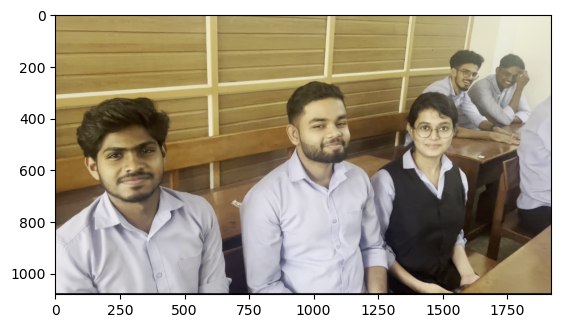

In [17]:
%%time
video = cv2.VideoCapture('Data/Video/input2.MOV')
count = 0
frames_arr = []
while video.isOpened():
    ret, frame = video.read()

    if not ret:
        break
    frames_arr.append(frame)                                         # Frames stored in frames_arr
    count += 1
video.release()
print(len(frames_arr), count)


img = frames_arr[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [18]:
%%time
frames = []
frames.append(frames_arr[0])
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(frames_arr)):
    keypoints1, descriptors1 = orb.detectAndCompute(frames[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(frames_arr[i], None)
    matches = bf.match(descriptors1, descriptors2)
    #matches = sorted(matches, key=lambda x: x.distance)
    
    if len(matches) < 200:
        frames.append(frames_arr[i])
print(len(frames))

55
CPU times: total: 25.7 s
Wall time: 36 s


In [19]:
%%time
detected_faces = []
img = frames_arr[0]
mp_face_detction = mp.solutions.face_detection
for frame in frames:
    with mp_face_detction.FaceDetection(model_selection = 1, min_detection_confidence = 0.5) as face_detection:
        results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            x_start, y_start = int(box.xmin * img.shape[1]), int(box.ymin * img.shape[0])
            x_end, y_end = int((box.xmin + box.width) * img.shape[1]), int((box.ymin + box.height) * img.shape[0])

            if x_start < 0 or y_start < 0:
                continue

            face = frame[y_start:y_end, x_start:x_end]
            face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            detected_faces.append(face)
print(len(detected_faces))


266
CPU times: total: 1.62 s
Wall time: 2.67 s


In [4]:
detected_faces = []
mp_face_detection = mp.solutions.face_detection
    # Initialize MediaPipe face detection module
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    
for frame in frames:
        # Convert frame to RGB (MediaPipe requires RGB input)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Detect faces in the current frame
    results = face_detection.process(frame_rgb)
        
    if results.detections:
        for detection in results.detections:
                # Get bounding box coordinates
            
            box = detection.location_data.relative_bounding_box
            x_start, y_start = int(box.xmin * img.shape[1]), int(box.ymin * img.shape[0])
            x_end, y_end = int((box.xmin + box.width) * img.shape[1]), int((box.ymin + box.height) * img.shape[0])

            if x_start < 0 or y_start < 0:
                continue

            face = frame[y_start:y_end, x_start:x_end]
            face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            detected_faces.append(face)
    
    # Release resources used by MediaPipe
face_detection.close()

In [5]:
print(len(detected_faces))

266


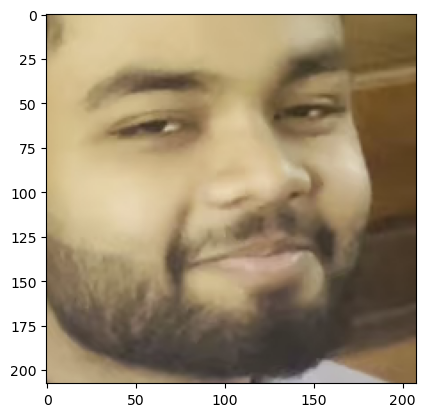

In [20]:
plt.imshow(detected_faces[0])

258


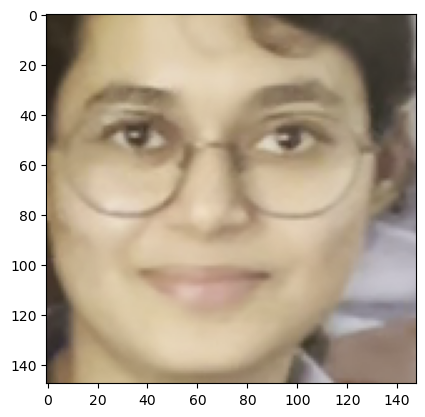

In [7]:
faces = []
faces.append(cv2.convertScaleAbs(detected_faces[0]))
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(detected_faces)):
    img2 = cv2.convertScaleAbs(detected_faces[i])

    

    keypoints1, descriptors1 = orb.detectAndCompute(faces[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    if descriptors2 is None:
        
        continue

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)

    #matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) < 200:
        faces.append(detected_faces[i])

detected_faces[:]=faces[:]
print(len(detected_faces))

plt.imshow(detected_faces[8])

In [ ]:
len(absent)

In [ ]:
plt.imshow(detected_faces[107])

In [ ]:
#image denoising using opencv
# %%time
# import numpy as np

# def deblur_image(image):
#     # Perform deblurring using your preferred method
#     # This could be a function like the one provided earlier
#     # For simplicity, I'll assume a placeholder deblurring function here
#     deblurred_image = cv2.medianBlur(image, 5)  # Placeholder deblurring function
#     return deblurred_image
 
# deblurred_face = deblur_image(detected_faces[107])
# plt.imshow(deblurred_face)
   

In [ ]:
model=df.find(img_path=deblurred_face,db_path='Data/known_faces',model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet",detector_backend='mediapipe')

In [ ]:
model[0]

In [ ]:
img = plt.imread('Data/WIN_20240217_22_04_07_Pro.jpg')

plt.imshow(img,cmap='gray')

In [ ]:
! git clone https://github.com/VITA-Group/DeblurGANv2

In [10]:
!cd  ./DeblurGANv2

The system cannot find the path specified.


In [ ]:
! pip install -r ./DeblurGANv2/requirements.txt --user

In [4]:
%cd DeblurGANv2/

C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2


In [11]:
import os
def current_path():
    print("Current working directory before")
    print(os.getcwd())
    print()
 
 
# Driver's code
# Printing CWD before
current_path()
 
# Changing the CWD
os.chdir('DeblurGANv2')
 
# Printing CWD after
current_path()

Current working directory before
C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2



FileNotFoundError: [WinError 2] The system cannot find the file specified: 'DeblurGANv2'

In [12]:
ls

 Volume in drive C is Acer
 Volume Serial Number is 9E98-D1E4

 Directory of C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2

18-02-2024  23:14    <DIR>          .
18-02-2024  23:36    <DIR>          ..
18-02-2024  23:14                56 .gitignore
18-02-2024  23:14             2,776 adversarial_trainer.py
18-02-2024  23:14             2,532 aug.py
18-02-2024  23:14    <DIR>          config
18-02-2024  23:14             5,332 dataset.py
18-02-2024  23:14    <DIR>          doc_images
18-02-2024  23:14             3,692 LICENSE
18-02-2024  23:14             2,186 metric_counter.py
18-02-2024  23:14    <DIR>          models
18-02-2024  23:14             2,994 picture_to_video.py
18-02-2024  23:14             5,158 predict.py
18-02-2024  23:14             5,726 README.md
18-02-2024  23:14               205 requirements.txt
18-02-2024  23:14             1,989 schedulers.py
18-02-2024  23:14    <DIR>          submit
18-02-2024  23:14                21 test.py
18-02-2024  23:14   

In [13]:
!wget -O blurred-image.jpeg https://github.com/amrrs/madebygoogle22-transcript/raw/main/blurred-image.jpeg

'wget' is not recognized as an internal or external command,
operable program or batch file.


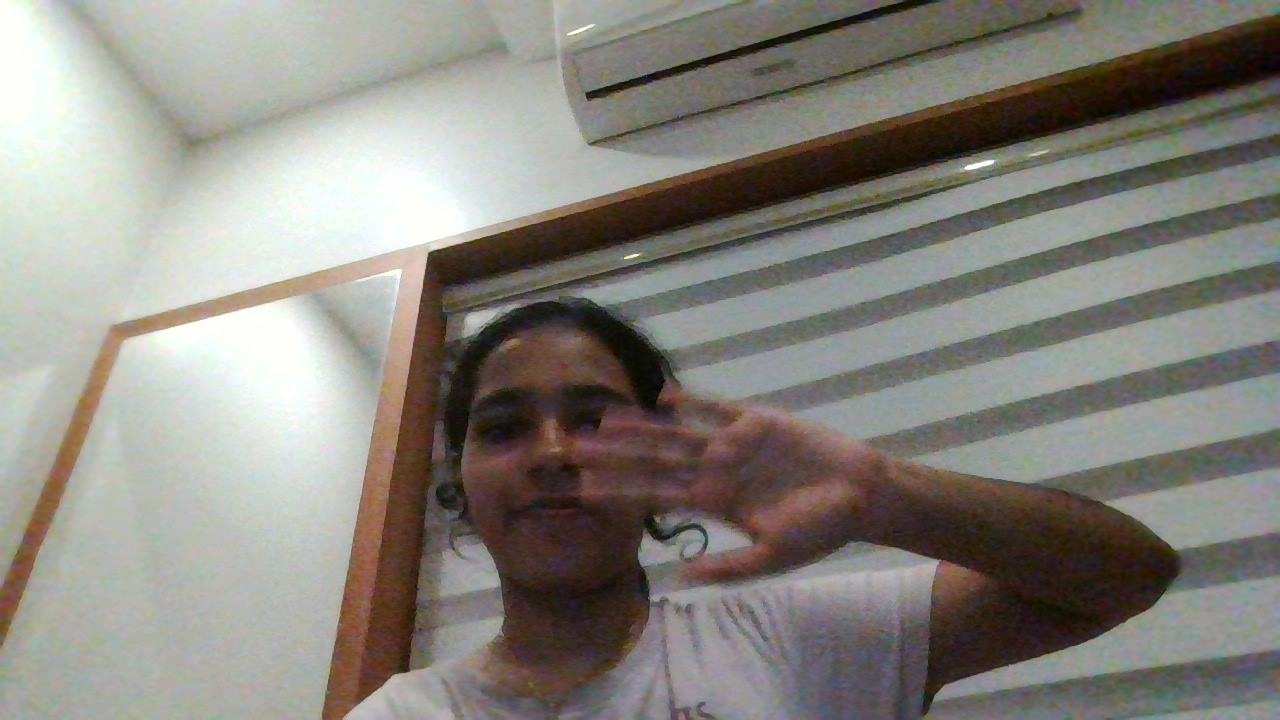

In [15]:
from IPython.display import Image
Image(filename='WIN_20240217_22_04_07_Pro.jpg')

In [16]:
!wget -O fpn_inception.h5 'https://docs.google.com/uc?export=download&id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR&confirm=t' #https://drive.google.com/open?id=1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR&authuser=0

'wget' is not recognized as an internal or external command,
operable program or batch file.
'id' is not recognized as an internal or external command,
operable program or batch file.
'confirm' is not recognized as an internal or external command,
operable program or batch file.
'authuser' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)
    
    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Provide the file ID and destination path
file_id = '1UXcsRVW-6KF23_TNzxw-xC0SzaMfXOaR'
destination = 'fpn_inception.h5'

# Download the file
download_file_from_google_drive(file_id, destination)


In [18]:
ls

 Volume in drive C is Acer
 Volume Serial Number is 9E98-D1E4

 Directory of C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2

18-02-2024  23:44    <DIR>          .
18-02-2024  23:43    <DIR>          ..
18-02-2024  23:14                56 .gitignore
18-02-2024  23:14             2,776 adversarial_trainer.py
18-02-2024  23:14             2,532 aug.py
18-02-2024  23:14    <DIR>          config
18-02-2024  23:14             5,332 dataset.py
18-02-2024  23:14    <DIR>          doc_images
18-02-2024  23:44             2,428 fpn_inception.h5
18-02-2024  23:14             3,692 LICENSE
18-02-2024  23:14             2,186 metric_counter.py
18-02-2024  23:14    <DIR>          models
18-02-2024  23:14             2,994 picture_to_video.py
18-02-2024  23:14             5,158 predict.py
18-02-2024  23:14             5,726 README.md
18-02-2024  23:14               205 requirements.txt
18-02-2024  23:14             1,989 schedulers.py
18-02-2024  23:14    <DIR>          submit
18-02-2024 

In [22]:
! python predict.py blurry-image.jpg

In [23]:
import os

# Provide the directory path
directory_path = 'submit/'

# List the contents of the directory
contents = os.listdir(directory_path)
print(contents)


['000001.png', '000019.png', '000201.png']


In [29]:
%%writefile predict1.py

import os
from glob import glob
from typing import Optional

import cv2
import numpy as np
import torch
import yaml
from fire import Fire
from tqdm import tqdm

from aug import get_normalize
from models.networks import get_generator


class Predictor:
    def __init__(self, weights_path: str, model_name: str = ''):
        with open('config/config.yaml',encoding='utf-8') as cfg:
            config = yaml.load(cfg, Loader=yaml.FullLoader)
        model = get_generator(model_name or config['model'])
        model.load_state_dict(torch.load(weights_path)['model'])
        self.model = model.cuda()
        self.model.train(True)
        # GAN inference should be in train mode to use actual stats in norm layers,
        # it's not a bug
        self.normalize_fn = get_normalize()

    @staticmethod
    def _array_to_batch(x):
        x = np.transpose(x, (2, 0, 1))
        x = np.expand_dims(x, 0)
        return torch.from_numpy(x)

    def _preprocess(self, x: np.ndarray, mask: Optional[np.ndarray]):
        x, _ = self.normalize_fn(x, x)
        if mask is None:
            mask = np.ones_like(x, dtype=np.float32)
        else:
            mask = np.round(mask.astype('float32') / 255)

        h, w, _ = x.shape
        block_size = 32
        min_height = (h // block_size + 1) * block_size
        min_width = (w // block_size + 1) * block_size

        pad_params = {'mode': 'constant',
                      'constant_values': 0,
                      'pad_width': ((0, min_height - h), (0, min_width - w), (0, 0))
                      }
        x = np.pad(x, **pad_params)
        mask = np.pad(mask, **pad_params)
        return map(self._array_to_batch, (x, mask)), h, w

    @staticmethod
    def _postprocess(x: torch.Tensor) -> np.ndarray:
        x, = x
        x = x.detach().cpu().float().numpy()
        x = (np.transpose(x, (1, 2, 0)) + 1) / 2.0 * 255.0
        return x.astype('uint8')

    def __call__(self, img: np.ndarray, mask: Optional[np.ndarray], ignore_mask=True) -> np.ndarray:
        (img, mask), h, w = self._preprocess(img, mask)
        with torch.no_grad():
            inputs = [img.cuda()]
            if not ignore_mask:
                inputs += [mask]
            pred = self.model(*inputs)
        return self._postprocess(pred)[:h, :w, :]
    def process_video(pairs, predictor, output_dir):
    for video_filepath, mask in tqdm(pairs):
        video_filename = os.path.basename(video_filepath)
        output_filepath = os.path.join(output_dir, os.path.splitext(video_filename)[0]+'_deblur.mp4')
        video_in = cv2.VideoCapture(video_filepath)
        fps = video_in.get(cv2.CAP_PROP_FPS)
        width = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frame_num = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
        video_out = cv2.VideoWriter(output_filepath, cv2.VideoWriter_fourcc(*'MP4V'), fps, (width, height))
        tqdm.write(f'process {video_filepath} to {output_filepath}, {fps}fps, resolution: {width}x{height}')
        for frame_num in tqdm(range(total_frame_num), desc=video_filename):
            res, img = video_in.read()
            if not res:
                break
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred = predictor(img, mask)
            pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
            def process_video(pairs, predictor, output_dir):
    for video_filepath, mask in tqdm(pairs):
        video_filename = os.path.basename(video_filepath)
        output_filepath = os.path.join(output_dir, os.path.splitext(video_filename)[0]+'_deblur.mp4')
        video_in = cv2.VideoCapture(video_filepath)
        fps = video_in.get(cv2.CAP_PROP_FPS)
        width = int(video_in.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video_in.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frame_num = int(video_in.get(cv2.CAP_PROP_FRAME_COUNT))
        video_out = cv2.VideoWriter(output_filepath, cv2.VideoWriter_fourcc(*'MP4V'), fps, (width, height))
        tqdm.write(f'process {video_filepath} to {output_filepath}, {fps}fps, resolution: {width}x{height}')
        for frame_num in tqdm(range(total_frame_num), desc=video_filename):
            res, img = video_in.read()
            if not res:
                break
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred = predictor(img, mask)
            pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
             video_out.write(pred)

def main(img_pattern: str,
         mask_pattern: Optional[str] = None,
         weights_path='fpn_inception.h5',
         out_dir='submit/',
         side_by_side: bool = False,
         video: bool = False):
    def sorted_glob(pattern):
        return sorted(glob(pattern))

    imgs = sorted_glob(img_pattern)
    masks = sorted_glob(mask_pattern) if mask_pattern is not None else [None for _ in imgs]
    pairs = zip(imgs, masks)
    names = sorted([os.path.basename(x) for x in glob(img_pattern)])
    predictor = Predictor(weights_path=weights_path)

    os.makedirs(out_dir, exist_ok=True)
    if not video:
        for name, pair in tqdm(zip(names, pairs), total=len(names)):
            f_img, f_mask = pair
            img, mask = map(cv2.imread, (f_img, f_mask))
             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            pred = predictor(img, mask)
            if side_by_side:
                pred = np.hstack((img, pred))
            pred = cv2.cvtColor(pred, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(out_dir, name),
                        pred)
    else:
        process_video(pairs, predictor, out_dir)

# def getfiles():
#     filenames = os.listdir(r'.\dataset1\blur')
#     print(filenames)
def get_files():
    list=[]
    for filepath,dirnames,filenames in os.walk(r'.\dataset1\blur'):
        for filename in filenames:
            list.append(os.path.join(filepath,filename))
    return list
if __name__ == '__main__':
  #  Fire(main)
#增加批量处理图片：
#     img_path=get_files()
#     for i in img_path:
#         main(i)
    main('WIN_20240217_22_04_07_Pro.jpg')
 

Overwriting predict1.py


In [30]:
ls

 Volume in drive C is Acer
 Volume Serial Number is 9E98-D1E4

 Directory of C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2

18-02-2024  23:52    <DIR>          .
18-02-2024  23:55    <DIR>          ..
18-02-2024  23:14                56 .gitignore
18-02-2024  23:45    <DIR>          __pycache__
18-02-2024  23:14             2,776 adversarial_trainer.py
18-02-2024  23:14             2,532 aug.py
18-02-2024  23:14    <DIR>          config
18-02-2024  23:14             5,332 dataset.py
18-02-2024  23:14    <DIR>          doc_images
18-02-2024  23:44             2,428 fpn_inception.h5
18-02-2024  23:52                 0 inceptionresnetv2-520b38e4.pth
18-02-2024  23:14             3,692 LICENSE
18-02-2024  23:14             2,186 metric_counter.py
18-02-2024  23:45    <DIR>          models
18-02-2024  23:14             2,994 picture_to_video.py
18-02-2024  23:14             5,158 predict.py
18-02-2024  23:55             6,253 predict1.py
18-02-2024  23:14             5,726 READ

In [31]:
import requests

url = "http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth"
output_path = "inceptionresnetv2-520b38e4.pth"

response = requests.get(url, stream=True, verify=False)
if response.status_code == 200:
    with open(output_path, 'wb') as f:
        f.write(response.content)
    print("Download completed")
else:
    print("Failed to download:", response.status_code)



C:\Users\wigar\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.lip6.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Download completed


In [32]:
! cp inceptionresnetv2-520b38e4.pth /root/.cache/torch/hub/checkpoints/

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [33]:
import shutil
import os

source_file = "inceptionresnetv2-520b38e4.pth"
destination_folder = "/root/.cache/torch/hub/checkpoints/"

# Check if the destination folder exists, create it if not
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

shutil.copy(source_file, destination_folder)
print("File copied successfully to", destination_folder)


File copied successfully to /root/.cache/torch/hub/checkpoints/


In [45]:
! python predict1.py WIN_20240217_22_04_07_Pro.jpg

Traceback (most recent call last):
  File "C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2\predict1.py", line 122, in <module>
    main('WIN_20240217_22_04_07_Pro.jpg')
  File "C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2\predict1.py", line 103, in main
    predictor = Predictor(weights_path=weights_path)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\wigar\Desktop\Project_jan25\Prototype\DeblurGANv2\predict1.py", line 21, in __init__
    model.load_state_dict(torch.load(weights_path)['model'])
                          ^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\wigar\anaconda3\Lib\site-packages\torch\serialization.py", line 1040, in load
    return _legacy_load(opened_file, map_location, pickle_module, **pickle_load_args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\wigar\anaconda3\Lib\site-packages\torch\serialization.py", line 1258, in _legacy_load
    magic_number = pickle_modul

In [61]:
os.getcwd()

'C:\\Users\\wigar\\Desktop\\Project_jan25\\Prototype\\DeblurGANv2'

In [62]:
cd ..

C:\Users\wigar\Desktop\Project_jan25\Prototype
